# Data-driven shoreline modelling at timescales of days to years
Joshua Simmons and Kristen Splinter 

In [1]:
# magic
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os,sys
import optuna
import multiprocess
import glob
import pandas as pd
import seaborn as sns

# Optimise the model
## Run optuna
Run optuna to grid search some hyperparameters and compare model performance with 5 fold CV at both Tairua and Narrabeen.
This is done using the `01a_Optuna_Run_Script.py` script.

In [4]:
trainingSettings = {
    'baseDir': '..',
    'site': 'tairua',
    'version': 3,
    'outputDir': os.path.join('..','results','optuna')
}

## b) Interrogate results to find optimum

In [10]:
combineResults = False # Only combine once
sqliteStr = 'sqlite:///{}'
baseDirStr = os.path.join(trainingSettings['outputDir'],'study{}_{}_v{:02d}.db')
print('Searching for studies in',baseDirStr.format('_*',trainingSettings['site'],trainingSettings['version']))
studies = glob.glob(baseDirStr.format('_*',trainingSettings['site'],trainingSettings['version']))
print('Found',len(studies),'studies')
outFile = baseDirStr.format('',trainingSettings['site'],trainingSettings['version'])
studies.sort()
baseStudyName = baseDirStr.format('',trainingSettings['site'],trainingSettings['version']).split(os.sep)[-1].replace('.db','')

if not os.path.exists(outFile):
    print('Creating new study',outFile)
    study = optuna.create_study(
        study_name=baseStudyName,
        storage=sqliteStr.format(outFile),
        direction='minimize',
        load_if_exists=False
    )
if combineResults:
    print('Combining results')
    for thisStudy in studies:
        thisStudyName = thisStudy.replace('.db','') #.split(os.sep)[-1]
        print(thisStudy)
        optuna.study.copy_study(
            from_study_name=thisStudyName,
            from_storage=sqliteStr.format(thisStudy),
            to_storage=sqliteStr.format(outFile)
        )

print('Loading study',outFile)
study_summary = optuna.study.get_all_study_summaries(storage=sqliteStr.format(outFile))
study = optuna.load_study(
    study_name=baseStudyName,
    storage=sqliteStr.format(outFile)
)

Searching for studies in ../results/optuna/study_*_tairua_v03.db
Found 4 studies
Loading study ../results/optuna/study_tairua_v03.db


In [11]:
for _ in study_summary:
    print(_.best_trial)

FrozenTrial(number=74, state=TrialState.COMPLETE, values=[6.178459942619227], datetime_start=datetime.datetime(2024, 3, 27, 4, 12, 39, 3660), datetime_complete=datetime.datetime(2024, 3, 27, 4, 22, 22, 263311), params={'peak_variable': False, 'num_layers': 3, 'size_factor': 500, 'dropout_rate': 0.3649088186873377, 'learning_rate': 0.0009904117715878512, 'learning_decay': 0.027187180982466676, 'batch_size': 20, 'epoch_num': 1000}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'peak_variable': CategoricalDistribution(choices=(True, False)), 'num_layers': IntDistribution(high=3, log=False, low=2, step=1), 'size_factor': IntDistribution(high=800, log=False, low=200, step=50), 'dropout_rate': FloatDistribution(high=0.4, log=False, low=0.1, step=None), 'learning_rate': FloatDistribution(high=0.001, log=True, low=5e-05, step=None), 'learning_decay': FloatDistribution(high=0.1, log=False, low=0.025, step=None), 'batch_size': IntDistribution(high=20, log=False, low=8, s

In [12]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [13]:
fig = optuna.visualization.plot_slice(study)
fig.show()

Available variables: ['peak_variable', 'num_layers', 'size_factor', 'dropout_rate', 'learning_rate', 'learning_decay', 'batch_size', 'epoch_num']


<Axes: xlabel='num_layers', ylabel='vals'>

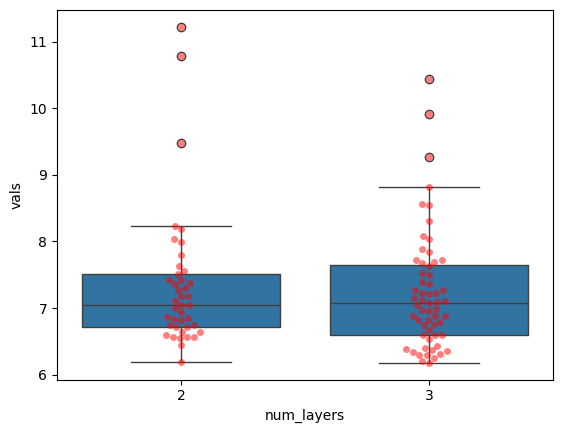

In [14]:
# quick check of a variable
available_vars = list(study.trials[0].params.keys())
print('Available variables:',available_vars)

this_var = 'num_layers'
vals = [_.values[0] for _ in study.trials]
params = [_.params[this_var] for _ in study.trials]

df = pd.DataFrame({'vals':vals,this_var:params})
sns.boxplot(x=this_var,y='vals',data=df,color='C0')
sns.swarmplot(x=this_var,y='vals',data=df,color='r',alpha=0.5)
